# Logistic Regression Notebook

## 1. The Dataset

In [1]:
# Import some standard libraries
import numpy as np
import pandas as pd
import pprint

In [2]:
df = pd.read_csv('LogRegDataset.csv')
features = df[['X1','X2']].to_numpy()
labels = df['labels'].to_numpy()

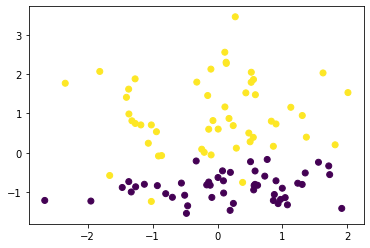

In [3]:
# Import plotting libraries to visualise dataset 
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(features[:, 0], features[:, 1], c=labels);

In [4]:
# Split dataset into training and test examples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

## 2. Custom Implementation

### 2.1 Overview of Logistic Regression

TODO

### 2.2 Coding Logistic Regression

#### 2.2.1 Helper Functions

In [5]:
"""
    Calculate the objective function value, here we are using the Conditional Log likelihood function 
    and returning the value when we pass our weights through this function. Ultimately, this function will 
    be utilised in training to see how much we are moving towards a solution; this is through 
    comparison of an objectuve value to the one computed before.
"""
def calc_obj_value(X,y,weights):
    # Precompute dot product 
    xw=np.dot(X,weights)
    
    # Compute the Conditional Log Likelihood (CLL) for each training example
    # l(w)=yXw-log(1+exp(Xw))
    cll=y*xw-np.log(1+np.exp(xw))
    
    # Sum over all examples to find the value
    return np.sum(cll)

In [6]:
"""
   Calculate the Gradient of the Conditional Log Likelihood Function (objective function), 
   this is to say we are taking partial derivatives for the objective function w.r.t. the weights. 
   Thus we will return an Nx1 vector, with N being the number of weights.
"""
def calc_gradient(X,y,weights):
    # Precompute dot product
    xw=np.dot(X,weights)
    # Calculate P(Y=1|X,W)
    # Our probability is modelled on the sigmoid function
    Y_pred=np.exp(xw)/(1+np.exp(xw))
    
    # Return the derivative of the Conditional Log Likelihood
    # df/dw_i=X^{T}(y-p(y=1|X,W))
    return np.dot(X.T,(y-Y_pred))

#### 2.2.2 Training the dataset

In [7]:
"""
    To train the dataset we follow the logistic regression algorithm. In train we loop over a convergence condition
    in which we keep updating weights using gradient descent (or ascent) till the changes in weights is small
    enough that is exceeeds the expectation of precision we set it. We take inputs of training data, 
    whilst also having a "verbose" option to offer us insight on how our algorithm progresses towards an optimum.
"""
def train(X_train,y_train,verbose=False):
    # Create a copy of X and way to not change original dataframe
    X=X_train.copy()
    y=y_train.copy()
    # Get rows and columns of our training data
    r,c=X_train.shape
    
    # Set step size and tolerance, we can fine tune these parameters to get better results for our models.
    # The current set up is a good starting point however for most problems.
    step=0.01
    tol=0.0001
    
    # Initialise weights with a vector of 0's
    weights=np.zeros((c+1,1))
    
    # Add a column of ones to accomidate our initial weight (or bias) w_0
    X=np.hstack((np.ones((X.shape[0], 1)),X))
    
    # Calculate an initial Objective Value Score and save to a list object
    # The list is useful perhaps if we want to analyse how quickly we converge to a solution.
    objVals=[]
    objVals.append(calc_obj_value(X,y,weights))
    
    # keep a track of iterations and convergence condition
    converged = False
    it=1
    
    # Iterate till convergence
    while not converged:
        
        grad=calc_gradient(X,y,weights)
        
        # Update weights
        weights=weights+step*grad
        
        newObj=calc_obj_value(X,y,weights)
        
        # Find difference between current and previous objective value
        ObjDiff=np.abs(newObj-objVals[-1])
        
        # Check Convergence
        if (ObjDiff<tol):
            # Since we have a negligible change between objective functions we can say we've reached a solution
            converged=True
            print("Convergence! Reached at Iteration {:d}".format(it))
        # Give regular update on where we are iteration wise, and our cost. 
        if(it % 100==0 and verbose==True):
            print('Iteration {:d}'.format(it))
            print("ObjValue Difference:", np.abs(newObj-objVals[-1]))
            
        it+=1
        
        objVals.append(newObj)
        
    # Pass our final weights and ObjVals for each iteration
    return weights, objVals

We can now generate our weights for the dataset we generated earlier!

In [8]:
# Generate weights and save our objective values for later analysis
w,objVals=train(X_train, y_train[:,np.newaxis])
# Print weights
for idx,weight in enumerate(w):
    print("w_{:d}: {:0.6f}".format(idx, weight[0]))

Convergence! Reached at Iteration 441
w_0: 1.010210
w_1: -1.366836
w_2: 4.834718


#### 2.2.3 Testing Dataset 

In [9]:
"""
    Create a function to predict the weights. Here we are passing through a testing dataset of labelled examples and
    the weights calculaed in the train function. By setting a decision boundary of P=0.5, we can calculate the 
    probability of a given an example being 1, then rounding it to the nearest integer to give its class. We return 
    the accuracy and also the predicted values to use as analysis later.
    
"""

def predict(X,y,weights):
    # Copy Dataframe and add a row of 1s to weight
    X=X.copy()
    X=np.hstack((np.ones((X.shape[0], 1)),X))
    
    # Find P(Y=1|X,w)
    xw=np.dot(X,weights)
    # Fit into our sigmoid function
    y_pred=np.exp(xw)/(1+np.exp(xw))
    
    # Find accuracy by summing correct examples
    acc=np.sum(np.round(y_pred)==y[:,np.newaxis])/y.shape[0]
    return acc,y_pred

In [10]:
# Predict 
accuracy,preds=predict(X_test,y_test,w)
print("Accuracy of our own logistic regression: {:.2f} ".format(accuracy))

Accuracy of our own logistic regression: 0.95 


We can see we have a good accuracy, especially given the noise we saw in the overall dataset. There's a number of reasons this could be and we can see why next in our analysis.

### 2.3 Analysis of Custom Logistic Regression

#### 2.3.1 Decision Boundary and Sigmoid Curve

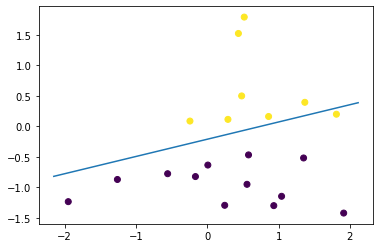

In [11]:
fig, ax = plt.subplots()

# Plot the testing data
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test);

# Get limits along X axis
x1=np.array(ax.get_xlim())
# We can reaarange the equation of weights and bias (x1*w_1+x2*w_2+w_0=0) to create a linear function of the form 
# y=mx+b and this will be our decision boundary. Note this only really works for a two feature/class problem. 
x2 = -(x1*w[1]+w[0])/w[2]

# Plot the decision boundary
ax.plot(x1,x2);

Here we can better see which point in our Logistic Regression we got wrong. We can also notice that the noise in the training dataset isn't as bad as was seen in the orignal dataset, with only a singular yellow point mixing with a flurry of purple. Also it should also be noted that this decision boundary could easily be moved slightly to the right to encompass the next purple point. We can see why this doesn't happen when looking at our points along the sigmoid curve. 

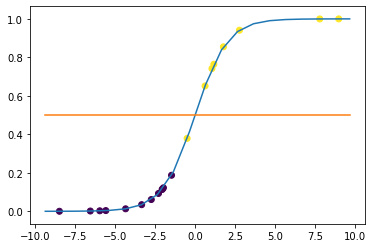

In [22]:
fig, ax = plt.subplots()
x_test_sum=np.sum(w[0]+np.dot(X_test,w[1:]),axis=1)

# Plot the training data along a sigmoid curve
ax.scatter(x_test_sum, preds,c=y_test)

# Plot the sigmoid curve too
x_width=np.arange(ax.get_xlim()[0],ax.get_xlim()[1])
ax.plot(x_width,np.exp(x_width)/(1+np.exp(x_width)))

# And finally our decision boundary
ax.plot(x_width, x_width*0+0.5)

The problem of the decision boundary not including a lone point should now be evidently clear. If not, we can see that it is caused as a result of our rounding decision in the prediction class. There we used 0.5 (or basically rounding to nearest whole integer) as a basis to decide what class an example should belong too; this is a good starter point but when fine tuning parameters, it may be neccesary to adjust this to better improve upon a models accuracy.

## 3. Sklearn Comparison

In [17]:
# Carry out Logistic Regression using sklearn module
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e15)
logreg.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.95


In [46]:
# Compare weights of each implementation
for idx, weight in enumerate(w):
    if idx==0: 
        print("Weight Difference for w_{:d} is {:0.6f}: ".format(idx,np.abs(weight - logreg.intercept_[0])[0]))
    else: 
         print("Weight Difference for w_{:d} is {:0.6f}: ".format(idx,np.abs(weight - logreg.coef_[0][idx-1])[0]))

Weight Difference for w_0 is 0.065048: 
Weight Difference for w_1 is 0.050269: 
Weight Difference for w_2 is 0.177135: 
